# Sources

1. Bowers, Johnson, Pease, "Prospective hot-spotting: The future of crime mapping?", Brit. J. Criminol. (2004) 44 641--658.  doi:10.1093/bjc/azh036

2. Johnson et al., "Prospective crime mapping in operational context", Home Office Online Report 19/07  [Police online library](http://library.college.police.uk/docs/hordsolr/rdsolr1907.pdf)

# Algorithm

### Grid the space

Divide the area of interest into a grid.  The grid is used for both the algorithm, and for data visualisation.  There is some discussion about reasonable grid sizes.  10m by 10m or 50m by 50m have been used.

### Aim of algorithm

We select "bandwidths": space/time regions of the data.  Common values are the look at events within 400m and the last 2 months (8 weeks).  For each grid cell, for each event falling in this range, we compute a weighting for the event, and then sum all the weightings to produce a (un-normalised) "risk intensity" for that cell.

### Choice of weights

I believe the original paper (1) is unclear on this.  The discussion on page 9 shows a formula involving "complete 1/2 grid widths" but does not give details as to how, _exactly_, such a distance is to be computed.  The next paragraph gives a couple of examples which seem unclear, as it simply talks about "neighbouring cell".  No formula is given for total weight, but we can infer it from the examples.

Let $t_i$ be the elapsed time between now and the event, and $d_i$ the distance of event $i$ from the centre of the grid cell we are interested in.  Then
$$ w = \sum_{t_i \leq t_\max, d_i \leq d_\max} \frac{1}{1+d_i} \frac{1}{1+t_i}. $$
For this to make sense, we introduce units:

   - $t_i$ is the number of whole weeks which have elapsed.  So if today is 20th March, and the event occurred on the 17th March, $t_i=0$.  If the event occurred on the 10th, $t_i=1$.
   - $d_i$ is the number of "whole 1/2 grid widths between the event" and the centre of the cell.  Again, this is slightly unclear, as an event occurring very near the edge of a cell would (thanks to Pythagoras) have $d_i=1$, while the example in the paper suggests always $d_i=0$ in this case.  We shall follow the examples, and take $d_i$ to be **the distance measured on the grid** (so neighbouring cells are distance 1 apart, and so forth).  This is still unclear, as are diagonally adjacent cells "neighbours" or not?  We give options in the code.
   
Paper (2) uses a different formula, and gives no examples:

$$ w = \sum_{t_i \leq t_\max, d_i \leq d_\max} \Big( 1 + \frac{1}{d_i} \Big) \frac{1}{t_i}. $$

where we told only that:

   - $t_i$ is the elapsed time (but using $1/t_i$ suggests very large weights for events occurring very close to the time of analysis).
   - $d_i$ is the "number of cells" between the event and the cell in question.  The text also notes: "Thus, if a crime occurred within the cell under consideration, the distance would be zero (actually, for computational reasons 1) if it
occurred within an adjacent cell, two, and so on."  What to do about diagonal cells is not specified: sensible choices might be that a cell diagonally offset from the cell of interest is either distance 2 or 3.  However, either choice would seem to introduce an anisotropic component which seems unjustified.

It is not clear to me that (2) gives the temporal and spatial bandwidths used.

### Coupled units

Notice that both weight functions couple the "units" of time and space.  For example, if we halve the cell width used, then (roughly speaking) each $d_i$ will double, while the $t_i$ remain unchanged.  This results in the time component now having a larger influence on the weight.

   - It hence seems sensible that we scale both time and distance together.
   - If we run one test with a grid size of 50m and the time unit as 7 days,
   - then another test could be a grid size of 25m, but also with the time unit as 3.5 days.

### Variations

Paper (2) introduces a variation of this method:

> For the second set of results for the prospective method, for each cell, the crime that confers
the most risk is identified and the cell is assigned the risk intensity value generated by that
one point.

Again, this is not made _entirely_ clear, but I believe it means that we look at the sum above, and instead of actually computing the sum, we compute each _summand_ and then take the largest value to be the weight.

### Generating predictions

The "risk intensity" for each grid cell is computed, and then displayed graphically as relative risk.  For example:

   - Visualise by plotting the top 1% of grid cells, top 5% and top 10% as different colours.  Paper (2) does this.
   - Visualise by generating a "heat map".  Paper (1) does this.
   
When using the risk intensity to make predictions, there are two reasonable choices:

1. Compute the risk intensity for today, using all the data up until today.  Treat this as a risk profile for the next few days in time.
2. For each day into the future we wish to predict, recompute the risk intensity.

The difference between (1) and (2) is that events may change their time-based weighting (or event fall out of the temporal bandwidth completely).  For example, if today is the 20th March and an event occurred on the 14th, we consider it as occuring zero whole weeks ago, and so it contributes a weight of $1/1 = 1$ (in the 1st formula, for example).  However, if we recompute the risk for the 22nd March, this event is now one whole week in the past, and so the weight becomes $1/2$.

### Aliasing issues

This issue falls under what I term an "aliasing issue" which comes about as we are taking continuous data and making it discrete:

   - We lay down a grid, making space discrete, because we measure distance as some multiple of "whole grid width".
   - We measure time in terms of "whole weeks" but seem to make day level predictions.
   
It would appear, a priori, that changing the offset of the grid (e.g. moving the whole grid 10m north) could cause a lot of events to jump from one grid cell to another.

### Implementation

We keep the grid for "prediction" purposes, but we allow a large range of "weights" to be plugged in, from various "guesses" as to what the exactly the original studies used, to variations of our own making.

Note, however, that this is still ultimately a "discrete" algorithm.  We give a variation which generates a continuous kernel (and then bins the result for visualisation / comparision purposes) as a different prediction method, see below.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import open_cp
import open_cp.prohotspot as phs

In [2]:
# Generate some random data
import datetime
times = [datetime.datetime(2017,3,10) + datetime.timedelta(days=np.random.randint(0,10)) for _ in range(20)]
times.sort()
xc = np.random.random(size=20) * 500
yc = np.random.random(size=20) * 500
points = open_cp.TimedPoints.from_coords(times, xc, yc)

In [3]:
region = open_cp.RectangularRegion(0,500, 0,500)
predictor = phs.ProspectiveHotSpot(region)
predictor.data = points
# To be correct, we should also adjust the weight, as now we have changed
# the ratio between space and time.
predictor.grid = 20
prediction = predictor.predict(times[-1], times[-1])

## Visualise the risk intensity directly

Our random data includes events from the past week, and from one (whole) week ago.  We visualise this by plotting the older events in a fainter colour.

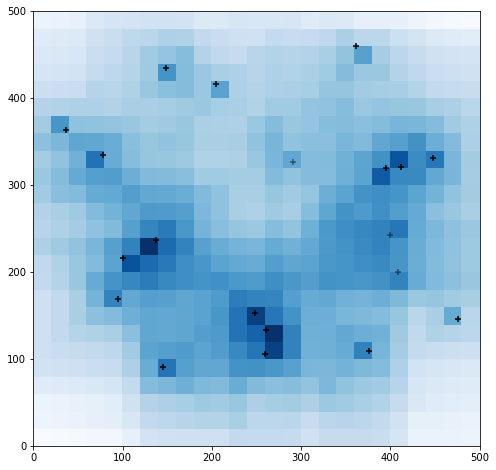

In [4]:
def plot_events_by_week(ax):
    for week in range(2):
        start = times[-1] - datetime.timedelta(days = 7 * week)
        end = times[-1] - datetime.timedelta(days = 7 * week + 7)
        mask = ~( (end < points.timestamps) & (points.timestamps <= start) )
        ax.scatter(np.ma.masked_where(mask, points.xcoords),
            np.ma.masked_where(mask, points.ycoords),
            marker="+", color="black", alpha = 1 - week * 0.5)

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])

ax.pcolormesh(*prediction.mesh_data(), prediction.intensity_matrix, cmap="Blues")
plot_events_by_week(ax)

## Visualise the top 1%, 5% and 10% of risk

It might seems strange that some events seem to confer so little risk that the cell they appear in does not reach the top 10%.  This is because the weight is additive, and so we strongly weight cells which are near a number of different events.  Remember also that we weight _recent_ events more.

Furthermore, because we look at the _percentiles_, but above view the data using a linear colouring, we are not really comparing like with like.  You can see this below, where we plot the (inverse of the) cumulative probability density and we see that the distribution has a heavy tail.

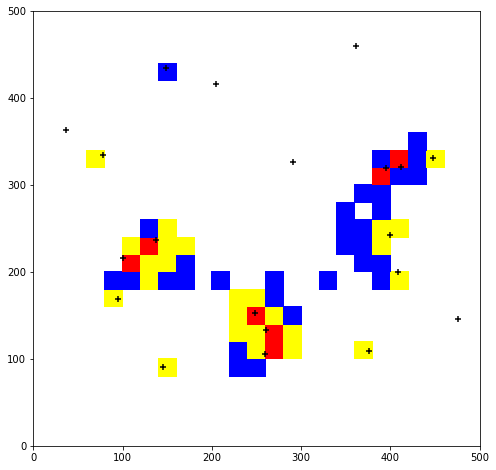

In [5]:
import matplotlib.colors

def make_risk_chart(prediction, ax=None):
    bins = np.array([0.9, 0.95, 0.99])
    binned = np.digitize(prediction.percentile_matrix(), bins)
    masked = np.ma.masked_where(binned == 0, binned)

    fixed_colour = matplotlib.colors.ListedColormap(["blue", "yellow", "red"])

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
    ax.pcolormesh(*prediction.mesh_data(), masked, cmap=fixed_colour)
    ax.scatter(points.xcoords, points.ycoords, marker="+", color="black")

make_risk_chart(prediction)

In [6]:
data = prediction.intensity_matrix.ravel().copy()
data.sort()

index = len(data) // 100

print("Intensity ranges from {} to {}".format(
    np.min(prediction.intensity_matrix), np.max(prediction.intensity_matrix)))
print("1%, 5% and 10% points are {}, {}, {}".format(
    data[len(data) - 1 - len(data) // 100],
    data[len(data) - 1 - 5 * len(data) // 100],
    data[len(data) - 1 - 10 * len(data) // 100]  ))

Intensity ranges from 0.125 to 2.5595238095238093
1%, 5% and 10% points are 2.1547619047619047, 1.7803571428571427, 1.6220238095238095


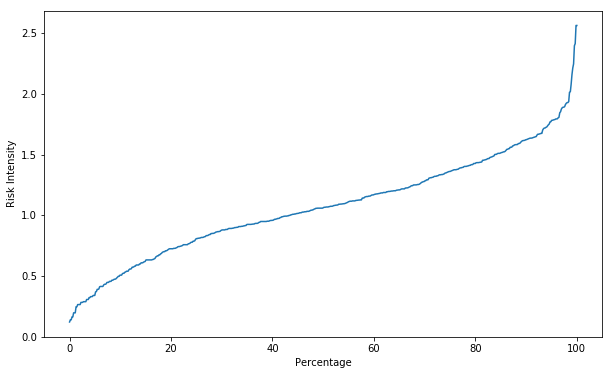

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(len(data)) * 100 / (len(data)-1), data)
ax.set_xlabel("Percentage")
ax.set_ylabel("Risk Intensity")
None

# Continuous kernel estimation

In [8]:
cts_predictor = phs.ProspectiveHotSpotContinuous()
cts_predictor.data = points
cts_predictor.grid = 20
cts_prediction = cts_predictor.predict(times[-1], times[-1])

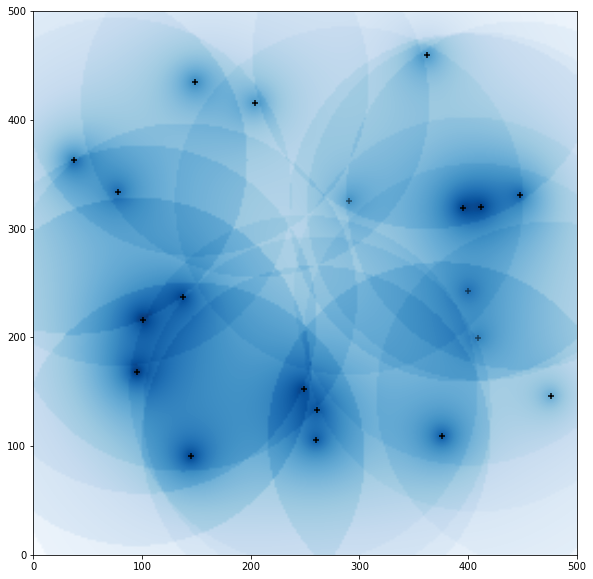

In [9]:
image_size = 250
density = np.empty((image_size, image_size))
for i in range(image_size):
    for j in range(image_size):
        density[j][i] = cts_prediction.risk((i + 0.5) / image_size * 500, (j + 0.5) / image_size * 500)
        
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(density, cmap="Blues", extent=(0,500,0,500),origin="bottom", interpolation="bilinear")
plot_events_by_week(ax)
ax.set(xlim=[0, 500], ylim=[0, 500])
None

We note that, unlike the "retrospective" hotspotting technique, the kernel is does not decay smoothly to zero.  This accounts for the "noisier" looking image.

In [10]:
grid = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(cts_prediction, region, 20, 20)

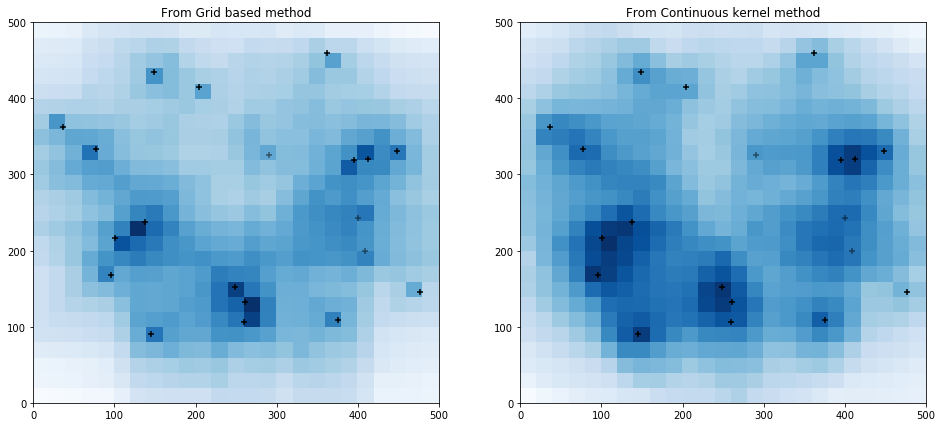

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].pcolormesh(*prediction.mesh_data(), prediction.intensity_matrix, cmap="Blues")
ax[1].pcolormesh(*grid.mesh_data(), grid.intensity_matrix, cmap="Blues")

for i, t in enumerate(["Grid based method", "Continuous kernel method"]):
    ax[i].set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
    plot_events_by_week(ax[i])
    ax[i].set_title("From "+t)

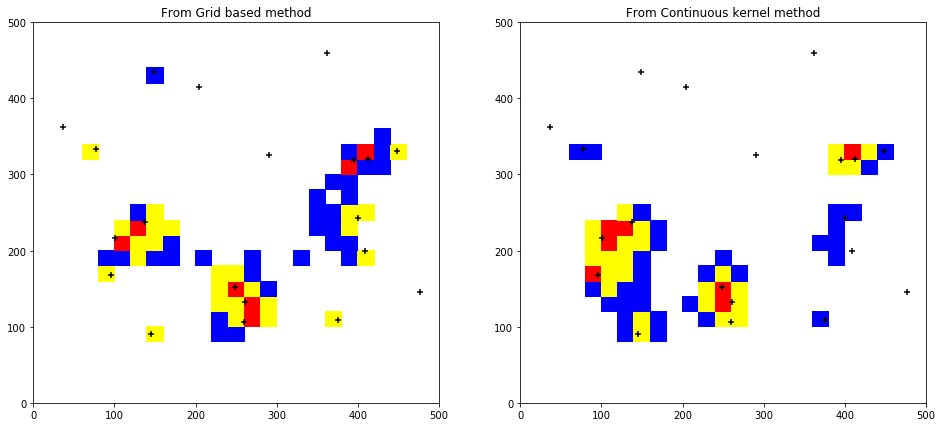

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

make_risk_chart(prediction, ax[0])
make_risk_chart(grid, ax[1])
for i, t in enumerate(["Grid based method", "Continuous kernel method"]):
    ax[i].set_title("From "+t)

So here we see some quite noticible differences between the purely grid based method, and the kernel density estimation method (which is only gridded as a final step).